# Titanic kaggle competition with SVM - Advanced

In [1]:
#import all the needed package
import numpy as np
import scipy as sp
import re
import pandas as pd
import sklearn
from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn import metrics
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.svm import SVC

## Let's load the processed data and feature scale Age and Fare

In [2]:
data = pd.read_csv('data/train_processed.csv', index_col=0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data[['Age', 'Fare']])
data[['Age', 'Fare']] = scaler.transform(data[['Age', 'Fare']])
data.head()

,Age,Fare,Parch,Pclass,SibSp,Female,EmbarkedNum,DeckNum,CabinNum,NumNames,Title_Dr,Title_Lady,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Title_Sir,Survived
PassengerId,,,,,,,,,,,,,,,,,,,
1,-0.595254,-0.502445,0,3,1,0,0,0,0,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.635996,0.786845,0,1,1,1,1,1,85,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.287441,-0.488854,0,3,0,1,0,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.405137,0.420730,0,1,1,1,0,1,123,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,0.405137,-0.486337,0,3,0,0,0,0,0,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Select the features from data, and convert to numpy arrays:

In [3]:
feature_cols=['Pclass','Age','SibSp','Parch','Fare','Female','Title_Dr','Title_Lady','Title_Master','Title_Miss','Title_Mr','Title_Mrs','Title_Rev','Title_Sir']
X=data[feature_cols].values
y=data['Survived'].values

We want to perform algorithm tuning with **CV** now, to avoid information leak, let's create a hold out set

In [4]:
#create a holdout set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

Below is a simple example of algorithm tuning with the rbf kernel of SVM. 

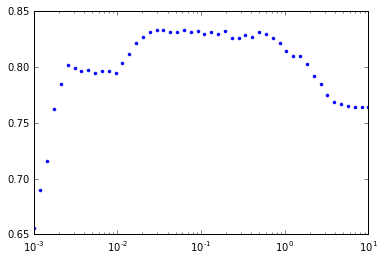

In [5]:
#tune the gamma parameter with our training set
scores_mean=[]
scores_std=[]
model=SVC()
model.C=1
gammas=np.logspace(-3,1,50)
for gamma in gammas:
    model.gamma=gamma
    scores=cross_val_score(model,X_train,y_train,cv=10,scoring='accuracy')
    scores_mean.append(np.mean(scores))
    scores_std.append(np.std(scores))
plt.semilogx(gammas,scores_mean,'.')
plt.show()


It seems that gamma is good in a broad range, Let's just take the middle of the flat part.

In [6]:
model.gamma=0.1
model.fit(X_train,y_train)
y_predta=model.predict(X_train)
y_pred=model.predict(X_test)
train_score=metrics.accuracy_score(y_train,y_predta)
test_score=metrics.accuracy_score(y_test,y_pred)

scores=cross_val_score(model,X,y,cv=10,scoring='accuracy')
cvscore=np.mean(scores)
cvscore_std=np.std(scores)
print(train_score,test_score,cvscore,cvscore_std)

0.839887640449 0.821229050279 0.830533140393 0.0326882223555


Of course, in real life you should perform parameter grid search in both **C** and **gamma**. Let's try out our new GridSearchCV tools learned in the morning. 

In [7]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
C_range = np.logspace(-3, 3, 10)
gamma_range = np.logspace(-3, 3, 10)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.3, random_state=42)
grid = GridSearchCV(SVC(kernel='rbf'), scoring="accuracy", param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train) 
print("The best parameters are %s with a score of %0.4f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 2.154434690031882, 'gamma': 0.021544346900318832} with a score of 0.8346


In [8]:
model.gamma=grid.best_params_['gamma']
model.C=grid.best_params_['C']
model.fit(X_train,y_train)
y_predta=model.predict(X_train)
y_pred=model.predict(X_test)
train_score=metrics.accuracy_score(y_train,y_predta)
test_score=metrics.accuracy_score(y_test,y_pred)

scores=cross_val_score(model,X,y,cv=10,scoring='accuracy')
cvscore=np.mean(scores)
cvscore_std=np.std(scores)
print(train_score,test_score,cvscore,cvscore_std)

0.835674157303 0.815642458101 0.832755078879 0.0316209466511


### Are we nessary perform better than the simpler model? 

The real test is to submit the file to kaggle and let their hold out set decide.
I did improve my result by ~0.03 with the newly added in name features. 

In [9]:
model.fit(X,y)
holdout_data = pd.read_csv('data/test_processed.csv')

# rescale age and fare as we did for training data.  This is critical
# Note that we can (and should) use the same scaler object we fit above to the training data
holdout_data[['Age', 'Fare']] = scaler.transform(holdout_data[['Age', 'Fare']])

#use our new features.
feature_cols=['Pclass','Age','SibSp','Parch','Fare','Female','Title_Dr','Title_Lady','Title_Master','Title_Miss','Title_Mr','Title_Mrs','Title_Rev','Title_Sir']
X_holdout=holdout_data[feature_cols].values

In [10]:
y_holdout=model.predict(X_holdout)
samplesubmit = pd.read_csv("data/titanic_submit_example.csv")
samplesubmit["Survived"]=np.int32(y_holdout)
samplesubmit.to_csv("data/titanic_submit_fancytitle.csv",index=False)